# **Data Preperation**

In [2]:
# Importing librairies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Load data 

survey = pd.read_csv('../digital_habits_vs_mental_health.csv')

In [4]:
#inspect the dataset 
survey.info()
survey.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   screen_time_hours            100000 non-null  float64
 1   social_media_platforms_used  100000 non-null  int64  
 2   hours_on_TikTok              100000 non-null  float64
 3   sleep_hours                  100000 non-null  float64
 4   stress_level                 100000 non-null  int64  
 5   mood_score                   100000 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 4.6 MB


,screen_time_hours,social_media_platforms_used,hours_on_TikTok,sleep_hours,stress_level,mood_score
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000
mean,6.003505,2.997820,2.401433,6.988489,6.179590,9.06076
std,1.987073,1.414452,1.079111,1.466330,2.045409,1.27847
min,1.000000,1.000000,0.200000,3.000000,1.000000,2.00000
25%,4.700000,2.000000,1.600000,6.000000,5.000000,8.00000
50%,6.000000,3.000000,2.300000,7.000000,6.000000,10.00000
75%,7.300000,4.000000,3.100000,8.000000,8.000000,10.00000
max,12.000000,5.000000,7.200000,10.000000,10.000000,10.00000


In [5]:
survey.head()

,screen_time_hours,social_media_platforms_used,hours_on_TikTok,sleep_hours,stress_level,mood_score
0,10.3,2,5.3,4.4,10,5
1,6.5,5,3.5,6.2,8,8
2,9.1,4,2.8,6.6,7,8
3,6.5,3,2.5,6.5,7,9
4,2.1,3,1.2,7.8,2,10


In [6]:
#Missing data 
survey.isna().sum()

screen_time_hours              0
social_media_platforms_used    0
hours_on_TikTok                0
sleep_hours                    0
stress_level                   0
mood_score                     0
dtype: int64

In [7]:
#New labeling column 

screen_time_bins = [0, 4, 8, 12]
labels = ['low', 'medium', 'high']

survey['screen_time_label'] = pd.cut(survey['screen_time_hours'], bins=screen_time_bins, labels=labels, include_lowest=True)


In [8]:
survey.groupby('screen_time_label', observed=False)['screen_time_hours'].agg(['min', 'max', 'size'])

,min,max,size
screen_time_label,,,
low,1.0,4.0,16424
medium,4.1,8.0,68296
high,8.1,12.0,15280


In [9]:
#Filtering for Analysis

low_screen_time_df = survey.query("screen_time_label == 'low'")
high_screen_time_df = survey.query("screen_time_label == 'high'")

In [10]:
low_screen_time_df.head()

,screen_time_hours,social_media_platforms_used,hours_on_TikTok,sleep_hours,stress_level,mood_score,screen_time_label
4,2.1,3,1.2,7.8,2,10,low
7,3.0,5,1.6,6.8,6,10,low
14,3.8,5,1.4,8.9,4,10,low
25,3.4,5,0.9,7.3,3,9,low
30,3.4,3,0.8,5.1,5,10,low


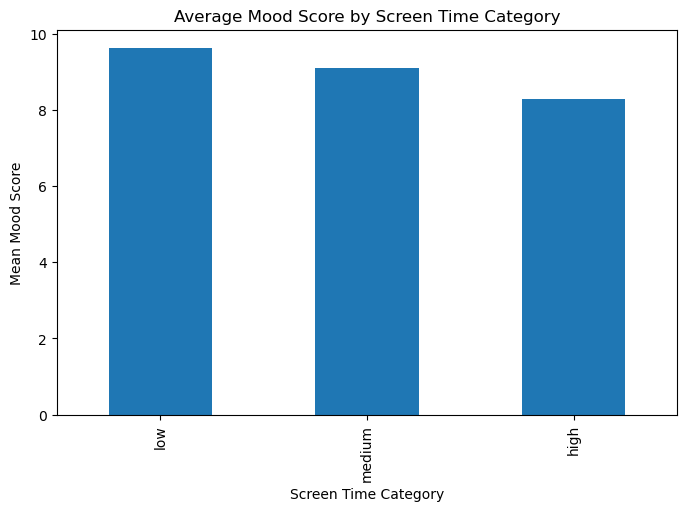

In [11]:
#plots 

plt.figure(figsize=(10,6))
survey.groupby('screen_time_label', observed=False)['mood_score'].mean().plot(
    kind='bar',
    figsize=(8,5),
)
plt.title("Average Mood Score by Screen Time Category")
plt.ylabel("Mean Mood Score")
plt.xlabel("Screen Time Category")
plt.show()

# **Data Analysis**

In [13]:
#Initial stat (observed effect)

mean_high = high_screen_time_df['mood_score'].mean()
mean_low  = low_screen_time_df['mood_score'].mean() 
mean_diff = mean_high - mean_low
print (f"The mean of High screen time Mood Score is {mean_high}")
print (f"The mean of Low screen time Mood Score is {mean_low}")
print(f"Mean difference is {mean_diff}")

The mean of High screen time Mood Score is 8.276767015706806
The mean of Low screen time Mood Score is 9.620920603994154
Mean difference is -1.344153588287348


In [14]:
#Permutation testing 

n_simulation = 10_000

mean_diff_perm = []

for _ in range(n_simulation):
    shuffled_labels = survey['screen_time_label'].sample(frac=1, replace=False).reset_index(drop=True)
    
    survey['shuffled_label'] = shuffled_labels
    
    mean_high_perm = survey.loc[survey['shuffled_label'] == 'high', 'mood_score'].mean()
    mean_low_perm  = survey.loc[survey['shuffled_label'] == 'low', 'mood_score'].mean()

    diff = mean_high_perm - mean_low_perm

    mean_diff_perm.append(diff)

Text(0, 0.5, 'Frequency')

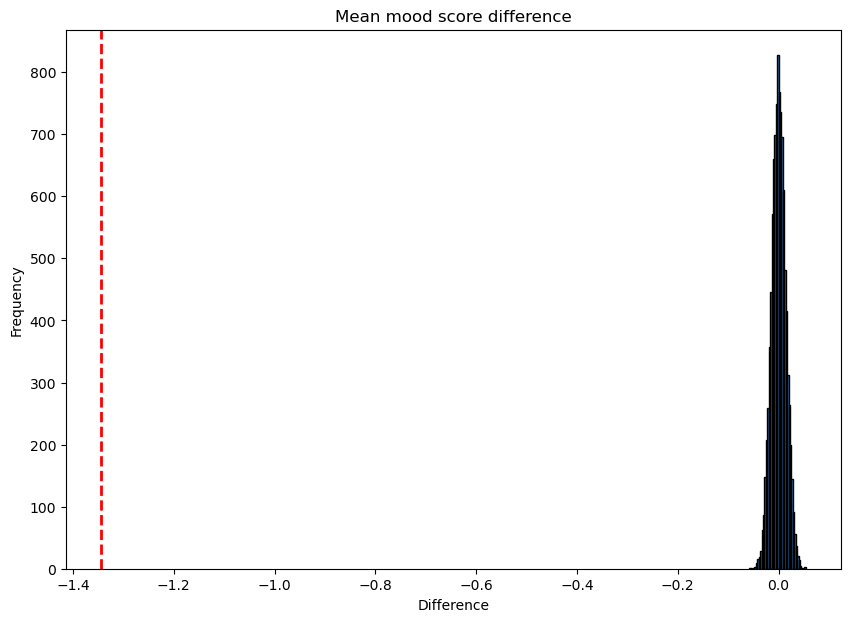

In [15]:
#plot 

fig_one = plt.figure(figsize=(10,7))

chart_one = fig_one.add_subplot(111)

chart_one.hist(mean_diff_perm, bins=40, edgecolor='black')
chart_one.axvline(mean_diff, color='red', linestyle='dashed', linewidth=2, label='Observed difference')
chart_one.set_title('Mean mood score difference')
chart_one.set_xlabel('Difference')
chart_one.set_ylabel('Frequency')

In [16]:
#p-value 

mean_diff_perm = np.array(mean_diff_perm)
p_value = np.mean(np.abs(mean_diff_perm) >= abs(mean_diff))
print(f"The p-value is: {p_value}")

The p-value is: 0.0


In [17]:
#Bootstrapping 1 (Median differnce between high and low screen time hours mood scores)

n_boot_one = 10_000
boot_diff_one = []

for _ in range(n_boot_one):
    sample_high = high_screen_time_df['mood_score'].sample(frac=1, replace=True)
    sample_low = low_screen_time_df['mood_score'].sample(frac=1, replace=True)

    med_diff = sample_high.median() - sample_low.median()
    boot_diff_one.append(med_diff)

#95% confidence interval 

lower = np.percentile(boot_diff_one, 2.5)
upper = np.percentile(boot_diff_one, 97.5)

print(f"95% Boostrapping CI for median difference is: [{lower}, {upper}]")

95% Boostrapping CI for median difference is: [-2.0, -1.0]


(array([4402.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,   56.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 5542.]),
 array([-2.        , -1.96666667, -1.93333333, -1.9       , -1.86666667,
        -1.83333333, -1.8       , -1.76666667, -1.73333333, -1.7       ,
        -1.66666667, -1.63333333, -1.6       , -1.56666667, -1.53333333,
        -1.5       , -1.46666667, -1.43333333, -1.4       , -1.36666667,
        -1.33333333, -1.3       , -1.26666667, -1.23333333, -1.2       ,
        -1.16666667, -1.13333333, -1.1       , -1.06666667, -1.03333333,
        -1.        ]),
 <BarContainer object of 30 artists>)

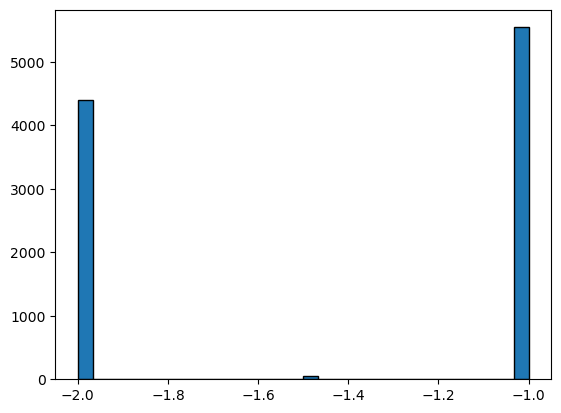

In [18]:
### plot

fig_two = plt.figure()

chart_boot_one = fig_two.add_subplot(111)

chart_boot_one.hist(boot_diff_one, bins=30, edgecolor='black')

In [19]:
#Bootstrapping 2 (Proportion of mood > 8 difference between high and low screen time)

n_boot_two = 10_000
boot_diff_two = []

for _ in range(n_boot_two):
    sample_high_screen = high_screen_time_df['mood_score'].sample(frac=1, replace=True)
    sample_low_screen = low_screen_time_df['mood_score'].sample(frac=1, replace=True)

    prop_high = (sample_high_screen > 8).mean()
    prop_low = (sample_low_screen > 8).mean()
    
    boot_diff_two.append(prop_high - prop_low)

#95% confidence interval 

lower_two = np.percentile(boot_diff_two, 2.5)
upper_two = np.percentile(boot_diff_two, 97.5)

print(f"95% Boostrapping CI for proportion difference (mood > 8) is: [{lower_two}, {upper_two}]")

95% Boostrapping CI for proportion difference (mood > 8) is: [-0.40474743097191446, -0.38670928589371195]


(array([4.000e+00, 7.000e+00, 1.800e+01, 2.200e+01, 7.900e+01, 1.000e+02,
        2.380e+02, 3.200e+02, 4.360e+02, 6.450e+02, 8.030e+02, 1.015e+03,
        1.004e+03, 1.059e+03, 1.045e+03, 9.080e+02, 7.150e+02, 5.980e+02,
        3.990e+02, 2.560e+02, 1.540e+02, 9.000e+01, 4.600e+01, 1.500e+01,
        1.300e+01, 5.000e+00, 5.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-0.41250612, -0.41124126, -0.40997641, -0.40871155, -0.40744669,
        -0.40618183, -0.40491698, -0.40365212, -0.40238726, -0.40112241,
        -0.39985755, -0.39859269, -0.39732783, -0.39606298, -0.39479812,
        -0.39353326, -0.39226841, -0.39100355, -0.38973869, -0.38847383,
        -0.38720898, -0.38594412, -0.38467926, -0.38341441, -0.38214955,
        -0.38088469, -0.37961983, -0.37835498, -0.37709012, -0.37582526,
        -0.37456041]),
 <BarContainer object of 30 artists>)

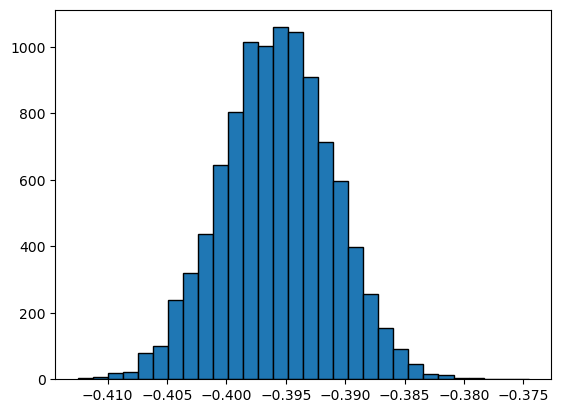

In [20]:
#plot

fig_three = plt.figure()

chart_boot_two = fig_three.add_subplot(111)

chart_boot_two.hist(boot_diff_two, bins=30, edgecolor='black')

| Element | Your Plan |
|:--|:--|
| **1. Topic / Question** | Does higher screen time relate to higher mood scores? |
| **2. Hypothesis** | There is no difference in mood score between high and low screen time respondents |
| **3. Outcome / Metric / Test Statistic** | My hypothesis ended up not being true, leading to rejecting the null hypothesis. I used mean difference in mood score for both high and low respondents for the test statistic. |
| **4. Units of Analysis** | Each row is one person’s mood and screen-time data. |
| **5. Data Source(s)** | I got the dataset from Kaggle and the link for it is: https://www.kaggle.com/datasets/abhishekdave9/digital-habits-vs-mental-health-dataset/data |
| **6. Uncertainty Metric** | Median difference and proportion difference |
| **7. Null Hypothesis** | Screen time makes no difference in mood|

---